### Dataset
[1](https://www.robots.ox.ac.uk/~vgg/data/vgg_face2/)
[2](http://vis-www.cs.umass.edu/lfw/)
[3](https://www.cs.tau.ac.il/~wolf/ytfaces/)


In [1]:
# !wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -P data
# !tar -xzf data/lfw-deepfunneled.tgz -C data

In [9]:
%reload_ext autoreload
%autoreload 2
import random
import numpy as np
import functools 
import operator 
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
import torchvision
from exitai.learner import Learner
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
image_folder = datasets.ImageFolder('data/lfw-deepfunneled')

In [20]:
class FIWDataset(DataLoader):
    def __init__(self, data_image, transform):
        self.dict_classes = {}
        self.imgs_anchor = []
        
        # load img and add to class dict
        for path, index_class in data_image:
            if index_class not in self.dict_classes:
                self.dict_classes[index_class] = []
            image = transform(Image.open(path))
            self.dict_classes[index_class].append(image)
        
        # keep all multiple images in the class to use it as Anchor images
        for idx in self.dict_classes.keys():
            num_img = len(self.dict_classes[idx])
            if num_img > 1:
                imgs_data = [(idx, img) for img in self.dict_classes[idx]]
                self.imgs_anchor.extend(imgs_data)
        
    def __getitem__(self, index):
        # anchor
        class_anchor, img_anchor = self.imgs_anchor[index]
        
        # positive
        img_pos = random.choice(self.dict_classes[class_anchor])
        while img_pos is img_anchor:
            img_pos = random.choice(self.dict_classes[class_anchor])
            
        # negative
        class_neg = random.choice(list(self.dict_classes.keys()))
        while class_neg is class_anchor:
            class_neg = random.choice(list(self.dict_classes.keys()))
        img_neg = random.choice(self.dict_classes[class_neg])
        
        return img_anchor, img_pos, img_neg
            
    
    def __len__(self):
        return len(self.imgs_anchor)

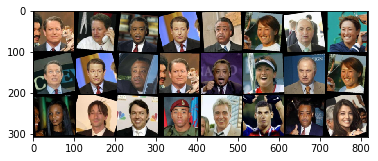

In [10]:
transform = transforms.Compose([
                        transforms.Resize((100,100)),
                        transforms.ToTensor()
                    ])
dataset_test = FIWDataset(image_folder.imgs[100:], transform)

data_loader_test = DataLoader(dataset_test, batch_size=8, shuffle=True, num_workers=8)
example_batch = next(iter(data_loader_test))

concatenated = torch.cat((example_batch[0], example_batch[1], example_batch[2]),0)
img = torchvision.utils.make_grid(concatenated)
img = img.numpy()

plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

### List num image of each class

In [16]:
# num_train = int(len(image_folder.samples)*.7)
# all = {}
# for _, inx_class in image_folder.samples[num_train:]:
#     if inx_class not in all:
#         all[inx_class] = 0
#     all[inx_class] += 1
# num_class = {}
# for idx in all:
#     if all[idx] not in num_class:
#         num_class[all[idx]] = 0
#     num_class[all[idx]] += 1
# num_class

{1: 1286,
 10: 9,
 15: 5,
 3: 89,
 4: 65,
 6: 22,
 2: 230,
 5: 37,
 8: 12,
 22: 2,
 37: 1,
 11: 6,
 19: 2,
 7: 13,
 20: 1,
 9: 8,
 18: 2,
 13: 3,
 30: 1,
 17: 3,
 27: 1,
 14: 2,
 32: 2,
 12: 1,
 26: 1,
 23: 2,
 52: 1,
 33: 2,
 25: 1,
 16: 2,
 144: 1,
 49: 1,
 24: 1}

### Create train data

In [30]:
transform_train = transforms.Compose([
                                   transforms.RandomAffine(15, scale=(.9,1.2)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
transform_test = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])

num_train = int(len(image_folder.samples)*.7)
dataset_train = FIWDataset(image_folder.imgs[num_train:], transform_train)
dataset_test = FIWDataset(image_folder.imgs[:num_train], transform_test)
data_loader_train = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=8)
data_loader_test = DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=8)

KeyboardInterrupt: 

### Model

In [28]:
class LeNetOneShot(nn.Module):
    def __init__(self):
        super(LeNetOneShot, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 20, 5, 1), # in_channels, out_channels, kernel_size, stride
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 50, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Linear(22*22*50, 500),
            nn.Linear(500, 10)
        )
        self.is_classification = True
        
    def forward(self, x):
        # [128, 3, 100, 100]
#         t = nn.Conv2d(3, 20, 5, 1)(x) # [128, 20, 96, 96]
#         t = nn.MaxPool2d(2, 2)(t) # [128, 20, 48, 48]
#         t = nn.Conv2d(20, 50, 5, 1)(t) # [128, 50, 44, 44]
#         t = nn.MaxPool2d(2, 2)(t) # [128, 50, 22, 22]
        
        output = self.cnn(x)
        print('output:', output.shape)
        output = output.view(-1, 50*22*22)
        output = self.fc(output)
        return output

    def name(self):
        return "LeNetOneShot"

In [24]:
from torchvision.models import resnet34

class FaceNetModel(nn.Module):
    def __init__(self, embedding_size, num_classes, pretrained=False):
        super (FaceNetModel, self).__init__()
        
        self.model            = resnet34(pretrained)
        self.embedding_size   = embedding_size
        self.model.fc         = nn.Linear(8192 , self.embedding_size) # 2048*3*3
        self.model.classifier = nn.Linear(self.embedding_size, num_classes)
    
    
    def l2_norm(self, input):
        input_size = input.size()
        buffer     = torch.pow(input, 2)
        normp      = torch.sum(buffer, 1).add_(1e-10)
        norm       = torch.sqrt(normp)
        _output    = torch.div(input, norm.view(-1, 1).expand_as(input))
        output     = _output.view(input_size)
    
        return output
    
    
    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = x.view(x.size(0), -1)
        x = self.model.fc(x)
        
        self.features = self.l2_norm(x)
        # Multiply by alpha = 10 as suggested in https://arxiv.org/pdf/1703.09507.pdf
        alpha         = 10
        self.features = self.features*alpha
        
        return self.model.classifier(self.features)

In [25]:
class TripletLoss(nn.Module):
    
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative):
        pos_dist   = F.pairwise_distance(anchor, positive)
        neg_dist   = F.pairwise_distance(anchor, negative)
        
        hinge_dist = torch.clamp(self.margin + pos_dist - neg_dist, min = 0.0)
        loss       = torch.mean(hinge_dist)
        return loss

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
margin = 0.2
criterion = TripletLoss(margin).to(device)
def model_loss_func(input_data, model, phase):
    input_anchor, input_positive, input_negative = input_data
    output_anchor = model(input_anchor)
    output_positive = model(input_positive)
    output_negative = model(input_negative)
    
    if phase=='train':
        # train only semi-hard
        distance_positive = F.pairwise_distance(output_anchor, output_positive)
        distance_negative = F.pairwise_distance(output_anchor, output_negative)
        mask_hard = distance_negative < distance_positive+margin
        num_hard = mask_hard.sum()
        if num_hard == 0:
            return 0, 0, 'skip' # if not semi-hard data, return the third params means skip update weight
        output_anchor = output_anchor[mask_hard]
        output_positive = output_positive[mask_hard]
        output_negative = output_negative[mask_hard]
        #-----------------------------------
    
    
    loss = criterion(output_anchor, output_positive, output_negative)
    return (output_anchor, output_positive, output_negative), loss

### Train
***BE CAREFUL***
The accuracy depends on threshold. Right now it's unreliable. We will find the best threshold later

In [29]:
model = LeNetOneShot()
# model = FaceNetModel(embedding_size=128, num_classes=10000)

def eval_func(input_data, output, loss):
    anchor, positive, negative = output
    positive_distance = F.pairwise_distance(anchor, positive)
    negative_distance = F.pairwise_distance(anchor, negative)
    return (positive_distance < negative_distance).sum().item()
learner = Learner(data_loader_train, data_loader_test, model)
learner.fit(model_loss_func, 0.002, num_epochs=100, eval_func=eval_func, early_stop='loss')

---- epoch:0 ------
output: torch.Size([128, 50, 59, 59])


RuntimeError: shape '[-1, 24200]' is invalid for input of size 22278400

### Finding threshod

In [109]:
def eval_func(input_data, output, loss):
        anchor, positive, negative = output
        positive_distance = F.pairwise_distance(anchor, positive)
        negative_distance = F.pairwise_distance(anchor, negative)
        return (positive_distance < negative_distance).sum().item()
learner.predict(model_loss_func, eval_func) 

   [test] Average loss: 0.0414, acc: 93.00%


In [110]:
def predict_with_threshold(threshold):
    def eval_func(input_data, output, loss):
        anchor, positive, negative = output
        
        # positive
        positive_distance = F.pairwise_distance(anchor, positive)
        positive_correct = positive_distance<threshold
        
        # negative
        negative_distance = F.pairwise_distance(anchor, negative)
        negative_correct = negative_distance>threshold
        return (positive_correct+negative_correct).sum().item()/2
    learner.predict(model_loss_func, eval_func)

In [114]:
for threshold in np.arange(0.8, 1.5, .01):
    print('threshold:', threshold)
    predict_with_threshold(threshold)

threshold: 0.8
   [test] Average loss: 0.0414, acc: 80.50%
threshold: 0.81
   [test] Average loss: 0.0414, acc: 80.50%
threshold: 0.8200000000000001
   [test] Average loss: 0.0414, acc: 80.50%
threshold: 0.8300000000000001
   [test] Average loss: 0.0414, acc: 80.50%
threshold: 0.8400000000000001
   [test] Average loss: 0.0414, acc: 81.00%
threshold: 0.8500000000000001
   [test] Average loss: 0.0414, acc: 81.50%
threshold: 0.8600000000000001
   [test] Average loss: 0.0414, acc: 81.50%
threshold: 0.8700000000000001
   [test] Average loss: 0.0414, acc: 82.50%
threshold: 0.8800000000000001
   [test] Average loss: 0.0414, acc: 82.50%
threshold: 0.8900000000000001
   [test] Average loss: 0.0414, acc: 83.50%
threshold: 0.9000000000000001
   [test] Average loss: 0.0414, acc: 83.50%
threshold: 0.9100000000000001
   [test] Average loss: 0.0414, acc: 83.50%
threshold: 0.9200000000000002
   [test] Average loss: 0.0414, acc: 83.00%
threshold: 0.9300000000000002
   [test] Average loss: 0.0414, acc: 

In [115]:
predict_with_threshold(1.0300000000000002)

   [test] Average loss: 0.0414, acc: 87.00%
